<a href="https://colab.research.google.com/github/GiX7000/deep-learning-with-tensorflow/blob/main/Part04.functional%26custom-models-custom-layers%26loss-functions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Learning with TensorFlow with Laurence Moroney, Part4

## Example 1. Sequential .vs Functional models.

In [ ]:
import tensorflow as tf
from tensorflow.python.keras.utils.vis_utils import plot_model
import pydot
from tensorflow.keras.utils import plot_model

In [ ]:
def build_model_with_sequential():
    
    # instantiate a Sequential class and linearly stack the layers of your model
    seq_model = tf.keras.models.Sequential([tf.keras.layers.Flatten(input_shape=(28, 28)),
                                            tf.keras.layers.Dense(128, activation=tf.nn.relu),
                                            tf.keras.layers.Dense(10, activation=tf.nn.softmax)])
    return seq_model


def build_model_with_functional():
    
    # instantiate the input Tensor
    input_layer = tf.keras.Input(shape=(28, 28))
    
    # stack the layers using the syntax: new_layer()(previous_layer)
    flatten_layer = tf.keras.layers.Flatten()(input_layer)
    first_dense = tf.keras.layers.Dense(128, activation=tf.nn.relu)(flatten_layer)
    output_layer = tf.keras.layers.Dense(10, activation=tf.nn.softmax)(first_dense)
    
    # declare inputs and outputs
    func_model = Model(inputs=input_layer, outputs=output_layer)
    
    return func_model

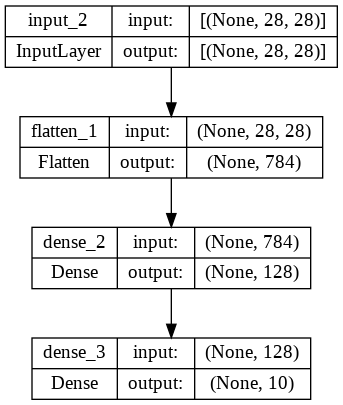

In [ ]:
model = build_model_with_functional()
#model = build_model_with_sequential()

# Plot model graph
plot_model(model, show_shapes=True, show_layer_names=True, to_file='model.png')

In [ ]:
# prepare fashion mnist dataset
mnist = tf.keras.datasets.fashion_mnist
(training_images, training_labels), (test_images, test_labels) = mnist.load_data()
training_images = training_images / 255.0
test_images = test_images / 255.0

# configure, train, and evaluate the model
model.compile(optimizer=tf.optimizers.Adam(),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.fit(training_images, training_labels, epochs=5)
model.evaluate(test_images, test_labels)

4422102/4422102 [==============================] - 0s 0us/step
Epoch 1/5
1875/1875 [==============================] - 11s 5ms/step - loss: 0.4953 - accuracy: 0.8258
Epoch 2/5
1875/1875 [==============================] - 9s 5ms/step - loss: 0.3737 - accuracy: 0.8650
Epoch 3/5
1875/1875 [==============================] - 9s 5ms/step - loss: 0.3333 - accuracy: 0.8780
Epoch 4/5
1875/1875 [==============================] - 8s 4ms/step - loss: 0.3109 - accuracy: 0.8866
Epoch 5/5
313/313 [==============================] - 1s 4ms/step - loss: 0.3620 - accuracy: 0.8700


[0.36201104521751404, 0.8700000047683716]

## Example 2. A multi-output Functional model.

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input
from sklearn.model_selection import train_test_split

In [ ]:
# helper functions

def format_output(data):
    y1 = data.pop('Y1')
    y1 = np.array(y1)
    y2 = data.pop('Y2')
    y2 = np.array(y2)
    return y1, y2


def norm(x):
    return (x - train_stats['mean']) / train_stats['std']


def plot_diff(y_true, y_pred, title=''):
    plt.scatter(y_true, y_pred)
    plt.title(title)
    plt.xlabel('True Values')
    plt.ylabel('Predictions')
    plt.axis('equal')
    plt.axis('square')
    plt.xlim(plt.xlim())
    plt.ylim(plt.ylim())
    plt.plot([-100, 100], [-100, 100])
    plt.show()


def plot_metrics(metric_name, title, ylim=5):
    plt.title(title)
    plt.ylim(0, ylim)
    plt.plot(history.history[metric_name], color='blue', label=metric_name)
    plt.plot(history.history['val_' + metric_name], color='green', label='val_' + metric_name)
    plt.show()

Prepare the data.

In [ ]:
# Get the data from UCI dataset
URL = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00242/ENB2012_data.xlsx'

# Use pandas excel reader
df = pd.read_excel(URL)
df = df.sample(frac=1).reset_index(drop=True)

# Split the data into train and test with 80 train / 20 test
train, test = train_test_split(df, test_size=0.2)
train_stats = train.describe()

# Get Y1 and Y2 as the 2 outputs and format them as np arrays
train_stats.pop('Y1')
train_stats.pop('Y2')
train_stats = train_stats.transpose()
train_Y = format_output(train)
test_Y = format_output(test)

# Normalize the training and test data
norm_train_X = norm(train)
norm_test_X = norm(test)

Build the model.

In [ ]:
# Define model layers.
input_layer = Input(shape=(len(train .columns),))
first_dense = Dense(units='128', activation='relu')(input_layer)
second_dense = Dense(units='128', activation='relu')(first_dense)

# Y1 output will be fed directly from the second dense
y1_output = Dense(units='1', name='y1_output')(second_dense)
third_dense = Dense(units='64', activation='relu')(second_dense)

# Y2 output will come via the third dense
y2_output = Dense(units='1', name='y2_output')(third_dense)

# Define the model with the input layer and a list of output layers
model = Model(inputs=input_layer, outputs=[y1_output, y2_output])

print(model.summary())

# Specify the optimizer, and compile the model with loss functions for both outputs
optimizer = tf.keras.optimizers.SGD(lr=0.001)
model.compile(optimizer=optimizer,
              loss={'y1_output': 'mse', 'y2_output': 'mse'},
              metrics={'y1_output': tf.keras.metrics.RootMeanSquaredError(),
                       'y2_output': tf.keras.metrics.RootMeanSquaredError()})

# Train the model for 500 epochs
history = model.fit(norm_train_X, train_Y,
                    epochs=500, batch_size=10, validation_data=(norm_test_X, test_Y))

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 8)]          0           []                               
                                                                                                  
 dense_4 (Dense)                (None, 128)          1152        ['input_3[0][0]']                
                                                                                                  
 dense_5 (Dense)                (None, 128)          16512       ['dense_4[0][0]']                
                                                                                                  
 dense_6 (Dense)                (None, 64)           8256        ['dense_5[0][0]']                
                                                                                            

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


62/62 [==============================] - 2s 7ms/step - loss: 243.0579 - y1_output_loss: 115.0681 - y2_output_loss: 127.9898 - y1_output_root_mean_squared_error: 10.7270 - y2_output_root_mean_squared_error: 11.3133 - val_loss: 43.5059 - val_y1_output_loss: 15.9923 - val_y2_output_loss: 27.5137 - val_y1_output_root_mean_squared_error: 3.9990 - val_y2_output_root_mean_squared_error: 5.2453
Epoch 2/500
62/62 [==============================] - 0s 3ms/step - loss: 31.7468 - y1_output_loss: 12.4307 - y2_output_loss: 19.3161 - y1_output_root_mean_squared_error: 3.5257 - y2_output_root_mean_squared_error: 4.3950 - val_loss: 28.3793 - val_y1_output_loss: 12.5431 - val_y2_output_loss: 15.8361 - val_y1_output_root_mean_squared_error: 3.5416 - val_y2_output_root_mean_squared_error: 3.9795
Epoch 3/500
62/62 [==============================] - 0s 6ms/step - loss: 25.4054 - y1_output_loss: 10.0594 - y2_output_loss: 15.3460 - y1_output_root_mean_squared_error: 3.1717 - y2_output_root_mean_squared_error:

In [ ]:
# Test the model and print loss and mse for both outputs
loss, Y1_loss, Y2_loss, Y1_rmse, Y2_rmse = model.evaluate(x=norm_test_X, y=test_Y)
print("Loss = {}, Y1_loss = {}, Y1_mse = {}, Y2_loss = {}, Y2_mse = {}".format(loss, Y1_loss, Y1_rmse, Y2_loss, Y2_rmse))

5/5 [==============================] - 0s 3ms/step - loss: 0.9364 - y1_output_loss: 0.2329 - y2_output_loss: 0.7035 - y1_output_root_mean_squared_error: 0.4826 - y2_output_root_mean_squared_error: 0.8387
Loss = 0.9363690614700317, Y1_loss = 0.23290909826755524, Y1_mse = 0.48260653018951416, Y2_loss = 0.7034599781036377, Y2_mse = 0.838725209236145


5/5 [==============================] - 0s 38ms/step


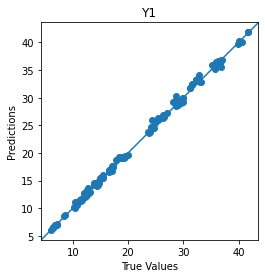

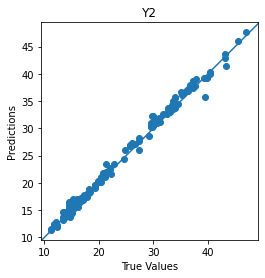

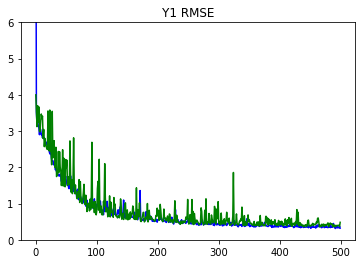

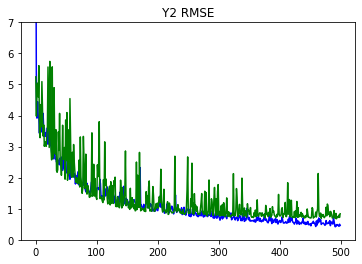

In [ ]:
# Plot the loss and mse
Y_pred = model.predict(norm_test_X)
plot_diff(test_Y[0], Y_pred[0], title='Y1')
plot_diff(test_Y[1], Y_pred[1], title='Y2')
plot_metrics(metric_name='y1_output_root_mean_squared_error', title='Y1 RMSE', ylim=6)
plot_metrics(metric_name='y2_output_root_mean_squared_error', title='Y2 RMSE', ylim=7)

## Example 3. A multi-input Siamese model with a custom loss function.

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout, Lambda
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.utils import plot_model
from tensorflow.keras import backend as K

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageFont, ImageDraw
import random

In [ ]:
# helper functions for preparing the data

def create_pairs(x, digit_indices):
    '''Positive and negative pair creation.
    Alternates between positive and negative pairs.
    '''
    pairs = []
    labels = []
    n = min([len(digit_indices[d]) for d in range(10)]) - 1
    
    for d in range(10):
        for i in range(n):
            z1, z2 = digit_indices[d][i], digit_indices[d][i + 1]
            pairs += [[x[z1], x[z2]]]
            inc = random.randrange(1, 10)
            dn = (d + inc) % 10
            z1, z2 = digit_indices[d][i], digit_indices[dn][i]
            pairs += [[x[z1], x[z2]]]
            labels += [1, 0]
            
    return np.array(pairs), np.array(labels)


def create_pairs_on_set(images, labels):
    
    digit_indices = [np.where(labels == i)[0] for i in range(10)]
    pairs, y = create_pairs(images, digit_indices)
    y = y.astype('float32')
    
    return pairs, y


def show_image(image):
    plt.figure()
    plt.imshow(image)
    plt.colorbar()
    plt.grid(False)
    plt.show()

In [ ]:
# load the dataset
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

# prepare train and test sets
train_images = train_images.astype('float32')
test_images = test_images.astype('float32')

# normalize values
train_images = train_images / 255.0
test_images = test_images / 255.0

# create pairs on train and test sets
tr_pairs, tr_y = create_pairs_on_set(train_images, train_labels)
ts_pairs, ts_y = create_pairs_on_set(test_images, test_labels)

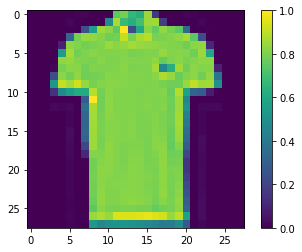

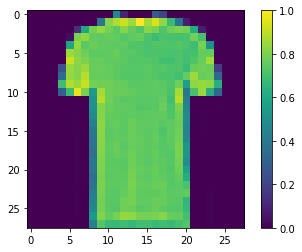

1.0


In [ ]:
# display a pair of images

# array index
this_pair = 10

# show images at this index
show_image(ts_pairs[this_pair][0])
show_image(ts_pairs[this_pair][1])

# print the label for this pair
print(ts_y[this_pair])

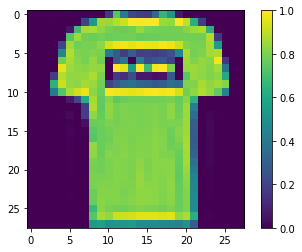

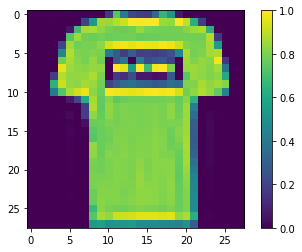

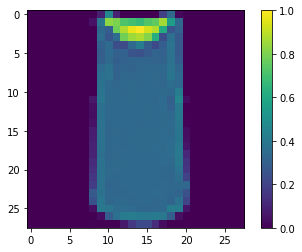

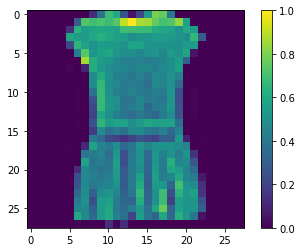

In [ ]:
# display other pairs

show_image(tr_pairs[:,0][0])
show_image(tr_pairs[:,0][1])

show_image(tr_pairs[:,1][0])
show_image(tr_pairs[:,1][1])

Build the model.

In [ ]:
# functions for model building 

def initialize_base_network():
    input = Input(shape=(28,28,), name="base_input")
    x = Flatten(name="flatten_input")(input)
    x = Dense(128, activation='relu', name="first_base_dense")(x)
    x = Dropout(0.1, name="first_dropout")(x)
    x = Dense(128, activation='relu', name="second_base_dense")(x)
    x = Dropout(0.1, name="second_dropout")(x)
    x = Dense(128, activation='relu', name="third_base_dense")(x)

    return Model(inputs=input, outputs=x)


def euclidean_distance(vects):
    x, y = vects
    sum_square = K.sum(K.square(x - y), axis=1, keepdims=True)
    return K.sqrt(K.maximum(sum_square, K.epsilon()))


def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)

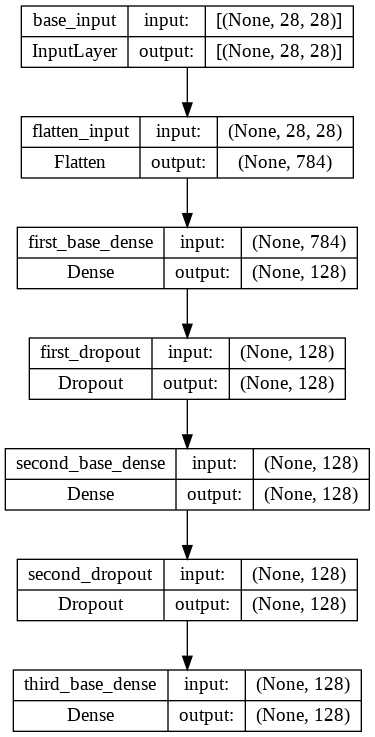

In [ ]:
# display base model's architecture
base_network = initialize_base_network()
plot_model(base_network, show_shapes=True, show_layer_names=True, to_file='base-model.png')

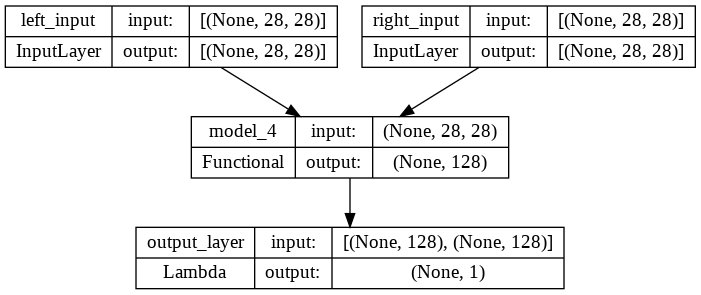

In [ ]:
# build the siamese network

# create the left input and point to the base network
input_a = Input(shape=(28,28,), name="left_input")
vect_output_a = base_network(input_a)

# create the right input and point to the base network
input_b = Input(shape=(28,28,), name="right_input")
vect_output_b = base_network(input_b)

# measure the similarity of the two vector outputs
output = Lambda(euclidean_distance, name="output_layer", output_shape=eucl_dist_output_shape)([vect_output_a, vect_output_b])

# specify the inputs and output of the model
model = Model([input_a, input_b], output)

# plot model graph
plot_model(model, show_shapes=True, show_layer_names=True, to_file='outer-model.png')

In [ ]:
# a custom loss function
def contrastive_loss_with_margin(margin):
    def contrastive_loss(y_true, y_pred):
        '''Contrastive loss from Hadsell-et-al.'06
        http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
        '''
        square_pred = K.square(y_pred)
        margin_square = K.square(K.maximum(margin - y_pred, 0))
        return K.mean(y_true * square_pred + (1 - y_true) * margin_square)
    return contrastive_loss

In [ ]:
# train the model
rms = RMSprop()
model.compile(loss=contrastive_loss_with_margin(margin=1), optimizer=rms)
history = model.fit([tr_pairs[:,0], tr_pairs[:,1]], tr_y, epochs=20, batch_size=128, validation_data=([ts_pairs[:,0], ts_pairs[:,1]], ts_y))

Epoch 1/20
938/938 [==============================] - 22s 22ms/step - loss: 0.1138 - val_loss: 0.0877
Epoch 2/20
938/938 [==============================] - 19s 20ms/step - loss: 0.0812 - val_loss: 0.0750
Epoch 3/20
938/938 [==============================] - 27s 29ms/step - loss: 0.0723 - val_loss: 0.0715
Epoch 4/20
938/938 [==============================] - 18s 19ms/step - loss: 0.0674 - val_loss: 0.0699
Epoch 5/20
938/938 [==============================] - 20s 21ms/step - loss: 0.0645 - val_loss: 0.0661
Epoch 6/20
938/938 [==============================] - 18s 19ms/step - loss: 0.0620 - val_loss: 0.0656
Epoch 7/20
938/938 [==============================] - 13s 14ms/step - loss: 0.0606 - val_loss: 0.0642
Epoch 8/20
938/938 [==============================] - 15s 16ms/step - loss: 0.0591 - val_loss: 0.0629
Epoch 9/20
938/938 [==============================] - 22s 24ms/step - loss: 0.0572 - val_loss: 0.0675
Epoch 10/20
938/938 [==============================] - 21s 22ms/step - loss: 0.056

In [ ]:
def compute_accuracy(y_true, y_pred):
    '''Compute classification accuracy with a fixed threshold on distances.
    '''
    pred = y_pred.ravel() < 0.5
    return np.mean(pred == y_true)

In [ ]:
# evaluate the model
loss = model.evaluate(x=[ts_pairs[:,0],ts_pairs[:,1]], y=ts_y)

y_pred_train = model.predict([tr_pairs[:,0], tr_pairs[:,1]])
train_accuracy = compute_accuracy(tr_y, y_pred_train)

y_pred_test = model.predict([ts_pairs[:,0], ts_pairs[:,1]])
test_accuracy = compute_accuracy(ts_y, y_pred_test)

print("Loss = {}, Train Accuracy = {} Test Accuracy = {}".format(loss, train_accuracy, test_accuracy))

625/625 [==============================] - 2s 3ms/step
Loss = 0.06178152561187744, Train Accuracy = 0.942465410901817 Test Accuracy = 0.9167667667667667


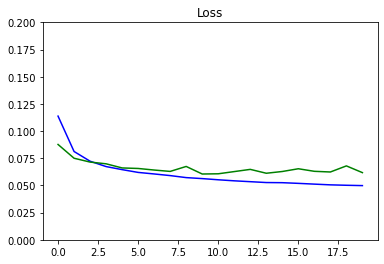

In [ ]:
# plot the results
def plot_metrics(metric_name, title, ylim=5):
    plt.title(title)
    plt.ylim(0,ylim)
    plt.plot(history.history[metric_name],color='blue',label=metric_name)
    plt.plot(history.history['val_' + metric_name],color='green',label='val_' + metric_name)


plot_metrics(metric_name='loss', title="Loss", ylim=0.2)

In [ ]:
# Matplotlib config
def visualize_images():
    plt.rc('image', cmap='gray_r')
    plt.rc('grid', linewidth=0)
    plt.rc('xtick', top=False, bottom=False, labelsize='large')
    plt.rc('ytick', left=False, right=False, labelsize='large')
    plt.rc('axes', facecolor='F8F8F8', titlesize="large", edgecolor='white')
    plt.rc('text', color='a8151a')
    plt.rc('figure', facecolor='F0F0F0')# Matplotlib fonts


# utility to display a row of digits with their predictions
def display_images(left, right, predictions, labels, title, n):
    plt.figure(figsize=(17,3))
    plt.title(title)
    plt.yticks([])
    plt.xticks([])
    plt.grid(None)
    left = np.reshape(left, [n, 28, 28])
    left = np.swapaxes(left, 0, 1)
    left = np.reshape(left, [28, 28*n])
    plt.imshow(left)
    plt.figure(figsize=(17,3))
    plt.yticks([])
    plt.xticks([28*x+14 for x in range(n)], predictions)
    for i,t in enumerate(plt.gca().xaxis.get_ticklabels()):
        if predictions[i] > 0.5: t.set_color('red') # bad predictions in red
    plt.grid(None)
    right = np.reshape(right, [n, 28, 28])
    right = np.swapaxes(right, 0, 1)
    right = np.reshape(right, [28, 28*n])
    plt.imshow(right)

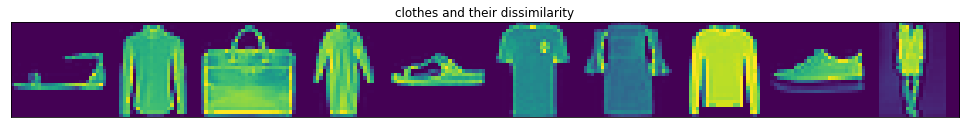

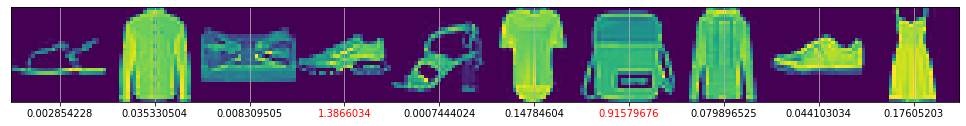

In [ ]:
# plot some pairs
y_pred_train = np.squeeze(y_pred_train)
indexes = np.random.choice(len(y_pred_train), size=10)
display_images(tr_pairs[:, 0][indexes], tr_pairs[:, 1][indexes], y_pred_train[indexes], tr_y[indexes], "clothes and their dissimilarity", 10)

A lower distance score indicates that two items are more similar and a higher distance score indicates the two items are different from each other.

## Example 4. Another multi-output Functional model.

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools

Pre-process the white wine dataset (TODO): we will add a new column named is_red in your dataframe to indicate if the wine is white or red. In the white wine dataset, you will fill the column is_red with zeros (0).

In [ ]:
# URL of the white wine dataset
URL = 'http://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-white.csv'

# load the dataset from the URL
white_df = pd.read_csv(URL, sep=";")

# fill the `is_red` column with zeros.
white_df["is_red"] = 0

# keep only the first of duplicate items
white_df = white_df.drop_duplicates(keep='first')

In [ ]:
print(white_df.alcohol[0])
print(white_df.alcohol[100])

8.8
9.1


Pre-process the red wine dataset (TODO): in the red wine dataset, you will fill in the column is_red with ones (1).

In [ ]:
# URL of the red wine dataset
URL = 'http://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv'

# load the dataset from the URL
red_df = pd.read_csv(URL, sep=";")

# fill the `is_red` column with ones.
red_df["is_red"] = 1

# keep only the first of duplicate items
red_df = red_df.drop_duplicates(keep='first')

In [ ]:
print(red_df.alcohol[0])
print(red_df.alcohol[100])

9.4
10.2


In [ ]:
# concatenate the datasets
df = pd.concat([red_df, white_df], ignore_index=True)

print(df.alcohol[0])
print(df.alcohol[100])

9.4
9.5


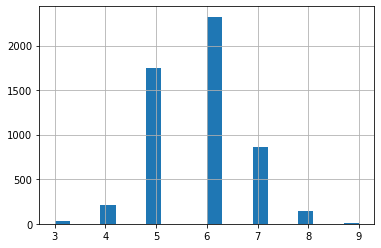

In [ ]:
# quality of the wines
df['quality'].hist(bins=20);

Imbalanced data (TODO): we can see from the plot above that the wine quality dataset is imbalanced. Since there are very few observations with quality equal to 3, 4, 8 and 9, we can drop these observations from your dataset. We can do this by removing data belonging to all classes except those > 4 and < 8.

9.4
10.9


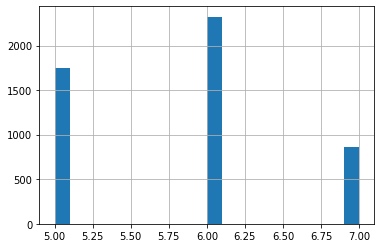

In [ ]:
# get data with wine quality greater than 4 and less than 8
df = df[(df['quality'] > 4) & (df['quality'] < 8 )]

# reset index and drop the old one
df = df.reset_index(drop=True)

print(df.alcohol[0])
print(df.alcohol[100])

# plot again to see the new range of data and quality
df['quality'].hist(bins=20);

In [ ]:
# train/test split

# split df into 80:20 train and test sets
train, test = train_test_split(df, test_size=0.2, random_state = 1)
                               
# split train into 80:20 train and val sets
train, val = train_test_split(train, test_size=0.2, random_state = 1)

In [ ]:
# explore the data
train_stats = train.describe()
train_stats.pop('is_red')
train_stats.pop('quality')
train_stats = train_stats.transpose()

train_stats

,count,mean,std,min,25%,50%,75%,max
fixed acidity,3155.0,7.221616,1.325297,3.80000,6.40000,7.00000,7.7000,15.60000
volatile acidity,3155.0,0.338929,0.162476,0.08000,0.23000,0.29000,0.4000,1.24000
citric acid,3155.0,0.321569,0.147970,0.00000,0.25000,0.31000,0.4000,1.66000
residual sugar,3155.0,5.155911,4.639632,0.60000,1.80000,2.80000,7.6500,65.80000
chlorides,3155.0,0.056976,0.036802,0.01200,0.03800,0.04700,0.0660,0.61100
free sulfur dioxide,3155.0,30.388590,17.236784,1.00000,17.00000,28.00000,41.0000,131.00000
total sulfur dioxide,3155.0,115.062282,56.706617,6.00000,75.00000,117.00000,156.0000,344.00000
density,3155.0,0.994633,0.003005,0.98711,0.99232,0.99481,0.9968,1.03898
pH,3155.0,3.223201,0.161272,2.72000,3.11000,3.21000,3.3300,4.01000
sulphates,3155.0,0.534051,0.149149,0.22000,0.43000,0.51000,0.6000,1.95000


Get the labels (TODO): the features and labels are currently in the same dataframe. We want to store the label columns is_red and quality separately from the feature columns. The following function, format_output, gets these two columns from the dataframe. format_output function also formats the data into numpy arrays.

In [ ]:
def format_output(data):
    is_red = data.pop('is_red')
    is_red = np.array(is_red)
    quality = data.pop('quality')
    quality = np.array(quality)
    return (quality, is_red)

In [ ]:
# format the output of the train set
train_Y = format_output(train)

# format the output of the val set
val_Y = format_output(val)
    
# format the output of the test set
test_Y = format_output(test)

Notice that after you get the labels, the train, val and test dataframes no longer contain the label columns, and contain just the feature columns.

In [ ]:
# let's take a look at the data
train.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
225,7.5,0.65,0.18,7.0,0.088,27.0,94.0,0.99915,3.38,0.77,9.4
3557,6.3,0.27,0.29,12.2,0.044,59.0,196.0,0.99782,3.14,0.40,8.8
3825,8.8,0.27,0.25,5.0,0.024,52.0,99.0,0.99250,2.87,0.49,11.4
1740,6.4,0.45,0.07,1.1,0.030,10.0,131.0,0.99050,2.97,0.28,10.8
1221,7.2,0.53,0.13,2.0,0.058,18.0,22.0,0.99573,3.21,0.68,9.9


In [ ]:
# function to normalize the data
def norm(x):
    return (x - train_stats['mean']) / train_stats['std']

In [ ]:
# normalize the train set
norm_train_X = norm(train)
    
# normalize the val set
norm_val_X = norm(val)
    
# normalize the test set
norm_test_X = norm(test)

Define the model.

In [ ]:
def base_model(inputs):
    
    # connect a Dense layer with 128 neurons and a relu activation
    x = tf.keras.layers.Dense(128, activation= tf.nn.relu)(inputs)
    
    # connect another Dense layer with 128 neurons and a relu activation
    x = tf.keras.layers.Dense(128, activation= tf.nn.relu)(x)
    return x

In [ ]:
def final_model(inputs):
    
    # get the base model
    x = base_model(inputs)

    # connect the output Dense layer for regression
    wine_quality = Dense(units='1', name='wine_quality')(x)

    # connect the output Dense layer for classification. this will use a sigmoid activation.
    wine_type = Dense(units='1', activation='sigmoid', name='wine_type')(x)

    # define the model using the input and output layers
    model = Model(inputs=inputs, outputs=[wine_quality, wine_type])

    return model

In [ ]:
inputs = tf.keras.layers.Input(shape=(11,))
rms = tf.keras.optimizers.RMSprop(lr=0.0001)
model = final_model(inputs)

model.compile(optimizer=rms, 
              loss = {'wine_type' : 'binary_crossentropy',
                      'wine_quality' : 'mean_squared_error'
                     },
              metrics = {'wine_type' : 'accuracy',
                         'wine_quality': tf.keras.metrics.RootMeanSquaredError()
                       }
             )

history = model.fit(norm_train_X, train_Y,
                    epochs = 180, validation_data=(norm_val_X, val_Y))

Epoch 1/180


/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/rmsprop.py:135: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


99/99 [==============================] - 6s 44ms/step - loss: 23.8395 - wine_quality_loss: 23.1992 - wine_type_loss: 0.6403 - wine_quality_root_mean_squared_error: 4.8166 - wine_type_accuracy: 0.7189 - val_loss: 16.7705 - val_wine_quality_loss: 16.1431 - val_wine_type_loss: 0.6275 - val_wine_quality_root_mean_squared_error: 4.0178 - val_wine_type_accuracy: 0.7364
Epoch 2/180
99/99 [==============================] - 0s 3ms/step - loss: 11.2820 - wine_quality_loss: 10.6831 - wine_type_loss: 0.5989 - wine_quality_root_mean_squared_error: 3.2685 - wine_type_accuracy: 0.7442 - val_loss: 6.7350 - val_wine_quality_loss: 6.1751 - val_wine_type_loss: 0.5600 - val_wine_quality_root_mean_squared_error: 2.4850 - val_wine_type_accuracy: 0.7376
Epoch 3/180
99/99 [==============================] - 3s 30ms/step - loss: 4.6731 - wine_quality_loss: 4.1728 - wine_type_loss: 0.5003 - wine_quality_root_mean_squared_error: 2.0427 - wine_type_accuracy: 0.7743 - val_loss: 3.1137 - val_wine_quality_loss: 2.671

Evaluation and predictions.

In [ ]:
# Gather the training metrics
loss, wine_quality_loss, wine_type_loss, wine_quality_rmse, wine_type_accuracy = model.evaluate(x=norm_val_X, y=val_Y)

print()
print(f'loss: {loss}')
print(f'wine_quality_loss: {wine_quality_loss}')
print(f'wine_type_loss: {wine_type_loss}')
print(f'wine_quality_rmse: {wine_quality_rmse}')
print(f'wine_type_accuracy: {wine_type_accuracy}')

25/25 [==============================] - 0s 2ms/step - loss: 0.3252 - wine_quality_loss: 0.2998 - wine_type_loss: 0.0254 - wine_quality_root_mean_squared_error: 0.5475 - wine_type_accuracy: 0.9949

loss: 0.32516923546791077
wine_quality_loss: 0.2997841238975525
wine_type_loss: 0.02538513019680977
wine_quality_rmse: 0.5475254654884338
wine_type_accuracy: 0.9949302673339844


In [ ]:
# predictions
predictions = model.predict(norm_test_X)
quality_pred = predictions[0]
type_pred = predictions[1]

print(quality_pred[0])

print(type_pred[0])
print(type_pred[944])

31/31 [==============================] - 0s 2ms/step
[5.965617]
[0.0001462]
[0.99999267]


Visualize model's performance.

In [ ]:
def plot_metrics(metric_name, title, ylim=5):
    plt.title(title)
    plt.ylim(0,ylim)
    plt.plot(history.history[metric_name],color='blue',label=metric_name)
    plt.plot(history.history['val_' + metric_name],color='green',label='val_' + metric_name)

def plot_confusion_matrix(y_true, y_pred, title='', labels=[0,1]):
    cm = confusion_matrix(y_true, y_pred)
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(cm)
    plt.title('Confusion matrix of the classifier')
    fig.colorbar(cax)
    ax.set_xticklabels([''] + labels)
    ax.set_yticklabels([''] + labels)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
          plt.text(j, i, format(cm[i, j], fmt),
                  horizontalalignment="center",
                  color="black" if cm[i, j] > thresh else "white")
    plt.show()

def plot_diff(y_true, y_pred, title = '' ):
    plt.scatter(y_true, y_pred)
    plt.title(title)
    plt.xlabel('True Values')
    plt.ylabel('Predictions')
    plt.axis('equal')
    plt.axis('square')
    plt.plot([-100, 100], [-100, 100])
    return plt

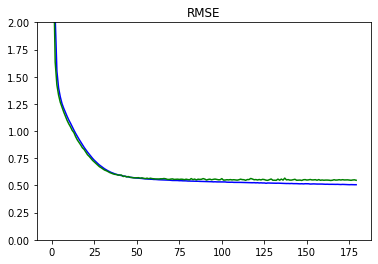

In [ ]:
plot_metrics('wine_quality_root_mean_squared_error', 'RMSE', ylim=2)

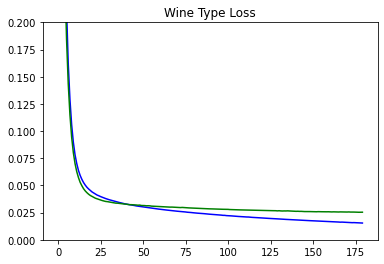

In [ ]:
plot_metrics('wine_type_loss', 'Wine Type Loss', ylim=0.2)

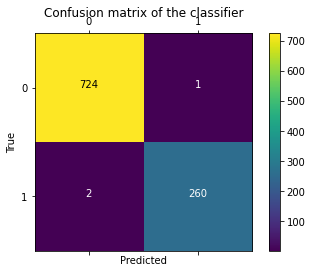

In [ ]:
plot_confusion_matrix(test_Y[1], np.round(type_pred), title='Wine Type', labels = [0, 1])

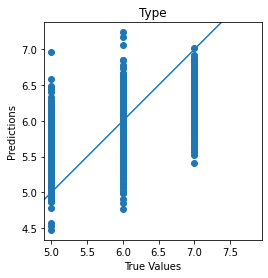

In [ ]:
scatter_plot = plot_diff(test_Y[0], quality_pred, title='Type')

## Example 5. A model with a custom Layer.

Define the quadratic layer (TODO): 3 state variables: a, b and c. The computation returned is a * x.^2 + b * x + c.

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Layer

class SimpleQuadratic(Layer):

    def __init__(self, units=32, activation=None):
        '''Initializes the class and sets up the internal variables'''
        super(SimpleQuadratic, self).__init__()
        self.units = units
        self.activation = tf.keras.activations.get(activation)
    
    def build(self, input_shape):
        '''Create the state of the layer (weights)'''
        # a and b should be initialized with random normal, c (or the bias) with zeros.
        # remember to set these as trainable.
        a_init = tf.random_normal_initializer()
        b_init = tf.random_normal_initializer()
        c_init = tf.zeros_initializer()
        
        self.a = tf.Variable(name = "kernel", initial_value = a_init(shape= (input_shape[-1], self.units), 
                                                                    dtype= "float32"), trainable = True)
        
        self.b = tf.Variable(name = "kernel", initial_value = b_init(shape= (input_shape[-1], self.units), 
                                                                    dtype= "float32"), trainable = True)
        
        self.c = tf.Variable(name = "bias", initial_value = c_init(shape= (self.units,), 
                                                                    dtype= "float32"), trainable = True)
   
    def call(self, inputs):
        '''Defines the computation from inputs to outputs'''
        result = tf.matmul(tf.math.square(inputs), self.a) + tf.matmul(inputs, self.b) + self.c
        return self.activation(result)

In [ ]:
mnist = tf.keras.datasets.mnist

(x_train, y_train),(x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(28, 28)),
  SimpleQuadratic(128, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(10, activation='softmax')
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.fit(x_train, y_train, epochs=5)
model.evaluate(x_test, y_test)

11490434/11490434 [==============================] - 0s 0us/step
Epoch 1/5
1875/1875 [==============================] - 27s 14ms/step - loss: 0.2714 - accuracy: 0.9193
Epoch 2/5
1875/1875 [==============================] - 17s 9ms/step - loss: 0.1332 - accuracy: 0.9601
Epoch 3/5
1875/1875 [==============================] - 9s 5ms/step - loss: 0.1005 - accuracy: 0.9685
Epoch 4/5
1875/1875 [==============================] - 10s 5ms/step - loss: 0.0817 - accuracy: 0.9744
Epoch 5/5
313/313 [==============================] - 1s 3ms/step - loss: 0.0786 - accuracy: 0.9756


[0.07860530912876129, 0.975600004196167]

## Example 6. Implementing a custom model: a mini ResNet.

In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.layers import Layer

Implement model subclasses.

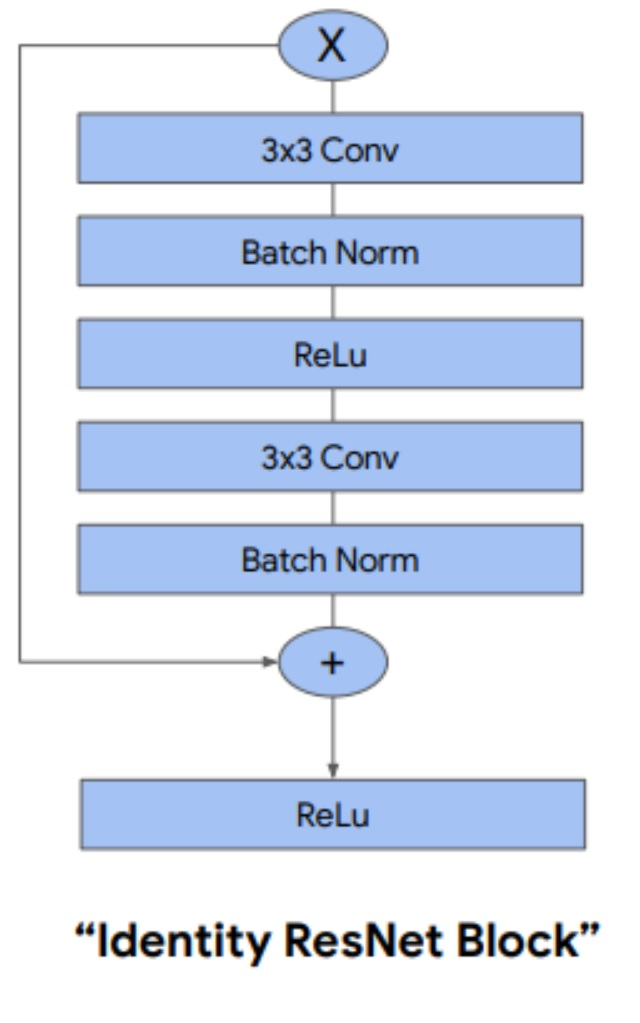

In [ ]:
class IdentityBlock(tf.keras.Model):
    def __init__(self, filters, kernel_size):   # number of filters and the kernel size as parameters
        super(IdentityBlock, self).__init__(name='')

        self.conv1 = tf.keras.layers.Conv2D(filters, kernel_size, padding='same')
        self.bn1 = tf.keras.layers.BatchNormalization()

        self.conv2 = tf.keras.layers.Conv2D(filters, kernel_size, padding='same')
        self.bn2 = tf.keras.layers.BatchNormalization()

        self.act = tf.keras.layers.Activation('relu')
        self.add = tf.keras.layers.Add()
    
    def call(self, input_tensor):
        x = self.conv1(input_tensor)
        x = self.bn1(x)
        x = self.act(x)

        x = self.conv2(x)
        x = self.bn2(x)

        x = self.add([x, input_tensor])
        x = self.act(x)
        return x

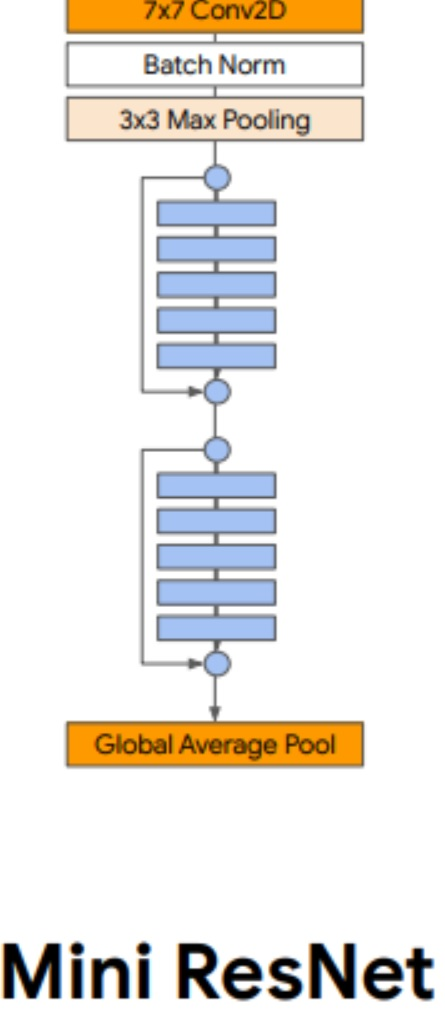

In [ ]:
class ResNet(tf.keras.Model):
    def __init__(self, num_classes):    # num_classes as a parameter
        super(ResNet, self).__init__()
        self.conv = tf.keras.layers.Conv2D(64, 7, padding='same')
        self.bn = tf.keras.layers.BatchNormalization()
        self.act = tf.keras.layers.Activation('relu')
        self.max_pool = tf.keras.layers.MaxPool2D((3, 3))

        # Use the Identity blocks that you just defined
        self.id1a = IdentityBlock(64, 3)
        self.id1b = IdentityBlock(64, 3)

        self.global_pool = tf.keras.layers.GlobalAveragePooling2D()
        self.classifier = tf.keras.layers.Dense(num_classes, activation='softmax')    # the output of the GlobalAveragePooling layer is a softmax classifier layer

    def call(self, inputs):
        x = self.conv(inputs)
        x = self.bn(x)
        x = self.act(x)
        x = self.max_pool(x)

        # insert the identity blocks in the middle of the network
        x = self.id1a(x)
        x = self.id1b(x)

        x = self.global_pool(x)
        return self.classifier(x)

Train the model.

In [ ]:
# utility function to normalize the images and return (image, label) pairs.
def preprocess(features):
    return tf.cast(features['image'], tf.float32) / 255., features['label']

# create a ResNet instance with 10 output units for MNIST
resnet = ResNet(10)
resnet.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# load and preprocess the dataset
dataset = tfds.load('mnist', split=tfds.Split.TRAIN, data_dir='./data')
dataset = dataset.map(preprocess).batch(32)

# train the model.
resnet.fit(dataset, epochs=5)

Dl Completed...:   0%|          | 0/4 [00:00<?, ? file/s]

Dataset mnist downloaded and prepared to ./data/mnist/3.0.1. Subsequent calls will reuse this data.
Epoch 1/5
1875/1875 [==============================] - 347s 184ms/step - loss: 0.1282 - accuracy: 0.9654
Epoch 2/5
1875/1875 [==============================] - 360s 192ms/step - loss: 0.0477 - accuracy: 0.9858
Epoch 3/5
1875/1875 [==============================] - 332s 177ms/step - loss: 0.0356 - accuracy: 0.9896
Epoch 4/5
1875/1875 [==============================] - 329s 176ms/step - loss: 0.0273 - accuracy: 0.9920
Epoch 5/5
1875/1875 [==============================] - 324s 173ms/step - loss: 0.0215 - accuracy: 0.9935


## Example 7. Implementing a custom model: a VGG network.

In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds

Some intuition..

In [ ]:
# Define a small class MyClass
class MyClass:
    def __init__(self):
        # One class variable 'a' is set to 1
        self.var1 = 1

# Create an object of type MyClass()
my_obj = MyClass()

In [ ]:
# __dict__ is a Python dictionary that contains the object's instance variables and values as key value pairs
my_obj.__dict__

{'var1': 1}

In [ ]:
# if you call vars() and pass in an object, it will call the object's __dict__ attribute, which is a Python dictionary
# containing the object's instance variables and their values as key
vars(my_obj)

{'var1': 1}

In [ ]:
# Add a new instance variable and give it a value
my_obj.var2 = 2

# Calls vars() again to see the object's instance variables
vars(my_obj)

{'var1': 1, 'var2': 2}

In [ ]:
# another way to add a new instance var as a string
vars(my_obj)['var3'] = 3

# Call vars() to see the object's instance variables
vars(my_obj)

{'var1': 1, 'var2': 2, 'var3': 3}

In [ ]:
# Use a for loop to increment the index 'i'
for i in range(4,10):
    # Format a string that is var
    vars(my_obj)[f'var{i}'] = 0
    
# View the object's instance variables!
vars(my_obj)

{'var1': 1,
 'var2': 2,
 'var3': 3,
 'var4': 0,
 'var5': 0,
 'var6': 0,
 'var7': 0,
 'var8': 0,
 'var9': 0}

In [ ]:
# 2 ways to format a string in python

# Format a string using f-string notation
i=1
print(f"var{i}")

# Format a string using .format notation
i=2
print("var{}".format(i))

var1
var2


In [ ]:
# access the variables of a class inside the class definition using vars(self)
class MyClass:
    def __init__(self):
        # Use vars(self) to access the class's dictionary of variables
        vars(self)['var1'] = 1

# Create an object of type MyClass()
my_obj = MyClass()
vars(my_obj)

{'var1': 1}

Create a custom VGG model.

In [ ]:
# generic VGG block
class Block(tf.keras.Model):
    def __init__(self, filters, kernel_size, repetitions, pool_size=2, strides=2):
        super(Block, self).__init__()
        self.filters = filters
        self.kernel_size = kernel_size
        self.repetitions = repetitions
        
        # Define a conv2D_0, conv2D_1, etc based on the number of repetitions
        for i in range(repetitions):
            
            # Define a Conv2D layer, specifying filters, kernel_size, activation and padding.
            vars(self)[f'conv2D_{i}'] = tf.keras.layers.Conv2D(self.filters, self.kernel_size, 
                                                               activation='relu', padding="same")
        
        # Define the max pool layer that will be added after the Conv2D blocks
        self.max_pool = tf.keras.layers.MaxPool2D(pool_size, strides)
  
    def call(self, inputs):
        # access the class's conv2D_0 layer
        conv2D_0 = vars(self)['conv2D_0']
        
        # Connect the conv2D_0 layer to inputs
        x = conv2D_0(inputs)

        # for the remaining conv2D_i layers from 1 to `repetitions` they will be connected to the previous layer
        for i in range(1,self.repetitions):
            # access conv2D_i by formatting the integer `i`. (hint: check how these were saved using `vars()` earlier)
            conv2D_i = vars(self)[f'conv2D_{i}']
            
            # Use the conv2D_i and connect it to the previous layer
            x = conv2D_i(x)

        # Finally, add the max_pool layer
        max_pool = self.max_pool(x)
        
        return max_pool

In [ ]:
# VGG network
class MyVGG(tf.keras.Model):

    def __init__(self, num_classes):
        super(MyVGG, self).__init__()

        # Creating blocks of VGG with the following 
        # (filters, kernel_size, repetitions) configurations
        self.block_a = Block(filters=64, kernel_size=3, repetitions=2)
        self.block_b = Block(filters=128, kernel_size=3, repetitions=2)
        self.block_c = Block(filters=256, kernel_size=3, repetitions=3)
        self.block_d = Block(filters=512, kernel_size=3, repetitions=3)
        self.block_e = Block(filters=512, kernel_size=3, repetitions=3)

        # Classification head
        # Define a Flatten layer
        self.flatten = tf.keras.layers.Flatten()
        # Create a Dense layer with 256 units and ReLU as the activation function
        self.fc = tf.keras.layers.Dense(units=256, activation="relu")
        # Finally add the softmax classifier using a Dense layer
        self.classifier = tf.keras.layers.Dense(units=num_classes, activation="softmax")

    def call(self, inputs):
        # Chain all the layers one after the other
        x = self.block_a(inputs)
        x = self.block_b(x)
        x = self.block_c(x)
        x = self.block_d(x)
        x = self.block_e(x)
        x = self.flatten(x)
        x = self.fc(x)
        x = self.classifier(x)
        return x

In [ ]:
# prepare the data and train the model

# Download the dataset
dataset = tfds.load('cats_vs_dogs', split=tfds.Split.TRAIN, data_dir='data/')

# Initialize VGG with the number of classes 
vgg = MyVGG(num_classes=2)

# Compile with losses and metrics
vgg.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Define preprocessing function
def preprocess(features):
    # Resize and normalize
    image = tf.image.resize(features['image'], (224, 224))
    return tf.cast(image, tf.float32) / 255., features['label']

# Apply transformations to dataset
dataset = dataset.map(preprocess).batch(32)

# Train the custom VGG model
vgg.fit(dataset, epochs=10)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/23262 [00:00<?, ? examples/s]

Shuffling data/cats_vs_dogs/4.0.0.incomplete06AAQ3/cats_vs_dogs-train.tfrecord*...:   0%|          | 0/23262 […

Dataset cats_vs_dogs downloaded and prepared to data/cats_vs_dogs/4.0.0. Subsequent calls will reuse this data.
Epoch 1/10
727/727 [==============================] - 162s 207ms/step - loss: 0.6800 - accuracy: 0.5665
Epoch 2/10
727/727 [==============================] - 145s 200ms/step - loss: 0.6394 - accuracy: 0.6386
Epoch 3/10
727/727 [==============================] - 145s 200ms/step - loss: 0.6129 - accuracy: 0.6641
Epoch 4/10
727/727 [==============================] - 153s 211ms/step - loss: 0.5985 - accuracy: 0.6759
Epoch 5/10
727/727 [==============================] - 149s 205ms/step - loss: 0.5883 - accuracy: 0.6865
Epoch 6/10
727/727 [==============================] - 144s 198ms/step - loss: 0.5799 - accuracy: 0.6948
Epoch 7/10
727/727 [==============================] - 144s 197ms/step - loss: 0.5726 - accuracy: 0.7006
Epoch 8/10
727/727 [==============================] - 149s 205ms/step - loss: 0.5660 - accuracy: 0.7049
Epoch 9/10
727/727 [==============================] - 15

## Example 8. Exploring callbacks.

In [ ]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import io
from PIL import Image

from tensorflow.keras.callbacks import TensorBoard, EarlyStopping, LearningRateScheduler, ModelCheckpoint, CSVLogger, ReduceLROnPlateau
%load_ext tensorboard

import os
import matplotlib.pylab as plt
import numpy as np
import math
import datetime
import pandas as pd

In [ ]:
# Download and prepare the horses or humans dataset
splits, info = tfds.load('horses_or_humans', as_supervised=True, with_info=True, split=['train[:80%]', 'train[80%:]', 'test'])

(train_examples, validation_examples, test_examples) = splits

num_examples = info.splits['train'].num_examples
num_classes = info.features['label'].num_classes

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/1027 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/horses_or_humans/3.0.0.incompleteE1GNZZ/horses_or_humans-train.tfrecord*...:  …

Generating test examples...:   0%|          | 0/256 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/horses_or_humans/3.0.0.incompleteE1GNZZ/horses_or_humans-test.tfrecord*...:   …

Dataset horses_or_humans downloaded and prepared to ~/tensorflow_datasets/horses_or_humans/3.0.0. Subsequent calls will reuse this data.


In [ ]:
SIZE = 150 
IMAGE_SIZE = (SIZE, SIZE)
BATCH_SIZE = 32

def format_image(image, label):
  image = tf.image.resize(image, IMAGE_SIZE) / 255.0
  return  image, label

train_batches = train_examples.shuffle(num_examples // 4).map(format_image).batch(BATCH_SIZE).prefetch(1)
validation_batches = validation_examples.map(format_image).batch(BATCH_SIZE).prefetch(1)
test_batches = test_examples.map(format_image).batch(1)


In [ ]:
for image_batch, label_batch in train_batches.take(1):
  pass

image_batch.shape

TensorShape([32, 150, 150, 3])

In [ ]:
# model's definition
def build_model(dense_units, input_shape=IMAGE_SIZE + (3,)):
  model = tf.keras.models.Sequential([
      tf.keras.layers.Conv2D(16, (3, 3), activation='relu', input_shape=input_shape),
      tf.keras.layers.MaxPooling2D(2, 2),
      tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
      tf.keras.layers.MaxPooling2D(2, 2),
      tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
      tf.keras.layers.MaxPooling2D(2, 2),
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(dense_units, activation='relu'),
      tf.keras.layers.Dense(2, activation='softmax')
  ])
  return model

Tensorboard.

In [ ]:
!rm -rf logs

In [ ]:
model = build_model(dense_units=256)
model.compile(
    optimizer='sgd',
    loss='sparse_categorical_crossentropy', 
    metrics=['accuracy'])
  
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir)

model.fit(train_batches, 
          epochs=10, 
          validation_data=validation_batches, 
          callbacks=[tensorboard_callback])

Epoch 1/10
26/26 [==============================] - 1s 29ms/step - loss: 0.6612 - accuracy: 0.6277 - val_loss: 0.6301 - val_accuracy: 0.8195
Epoch 2/10
26/26 [==============================] - 1s 24ms/step - loss: 0.6211 - accuracy: 0.7092 - val_loss: 0.6150 - val_accuracy: 0.5854
Epoch 3/10
26/26 [==============================] - 1s 52ms/step - loss: 0.5563 - accuracy: 0.7311 - val_loss: 0.5102 - val_accuracy: 0.8439
Epoch 4/10
26/26 [==============================] - 1s 26ms/step - loss: 0.4989 - accuracy: 0.7968 - val_loss: 0.4287 - val_accuracy: 0.8829
Epoch 5/10
26/26 [==============================] - 1s 30ms/step - loss: 0.4474 - accuracy: 0.8054 - val_loss: 0.3729 - val_accuracy: 0.8927
Epoch 6/10
26/26 [==============================] - 1s 26ms/step - loss: 0.4047 - accuracy: 0.8297 - val_loss: 0.3182 - val_accuracy: 0.9122
Epoch 7/10
26/26 [==============================] - 1s 25ms/step - loss: 0.3103 - accuracy: 0.8917 - val_loss: 0.3244 - val_accuracy: 0.8683
Epoch 8/10
26

In [ ]:
# load the extension
%load_ext tensorboard

In [ ]:
# run tensorboard
%tensorboard --logdir logs

Find more for TensorBoard here: https://www.tensorflow.org/tensorboard.

Model checkpoint.

In [ ]:
model = build_model(dense_units=256)
model.compile(
    optimizer='sgd',
    loss='sparse_categorical_crossentropy', 
    metrics=['accuracy'])
  
model.fit(train_batches, 
          epochs=5, 
          validation_data=validation_batches, 
          verbose=2,
          callbacks=[ModelCheckpoint('weights.{epoch:02d}-{val_loss:.2f}.h5', verbose=1),
          ])

Epoch 1/5

Epoch 1: saving model to weights.01-0.65.h5
26/26 - 1s - loss: 0.6887 - accuracy: 0.5511 - val_loss: 0.6488 - val_accuracy: 0.6000 - 1s/epoch - 40ms/step
Epoch 2/5

Epoch 2: saving model to weights.02-0.60.h5
26/26 - 1s - loss: 0.6422 - accuracy: 0.6168 - val_loss: 0.6035 - val_accuracy: 0.7317 - 1s/epoch - 43ms/step
Epoch 3/5

Epoch 3: saving model to weights.03-0.73.h5
26/26 - 1s - loss: 0.5804 - accuracy: 0.6971 - val_loss: 0.7267 - val_accuracy: 0.5024 - 942ms/epoch - 36ms/step
Epoch 4/5

Epoch 4: saving model to weights.04-0.51.h5
26/26 - 1s - loss: 0.5722 - accuracy: 0.6995 - val_loss: 0.5148 - val_accuracy: 0.8390 - 964ms/epoch - 37ms/step
Epoch 5/5

Epoch 5: saving model to weights.05-0.41.h5
26/26 - 1s - loss: 0.4836 - accuracy: 0.8017 - val_loss: 0.4138 - val_accuracy: 0.9024 - 518ms/epoch - 20ms/step


In [ ]:
model = build_model(dense_units=256)
model.compile(
    optimizer='sgd',
    loss='sparse_categorical_crossentropy', 
    metrics=['accuracy'])
  
model.fit(train_batches, 
          epochs=5, 
          validation_data=validation_batches, 
          verbose=2,
          callbacks=[ModelCheckpoint('saved_model', verbose=1)
          ])

Epoch 1/5

Epoch 1: saving model to saved_model


26/26 - 2s - loss: 0.6708 - accuracy: 0.5852 - val_loss: 0.6500 - val_accuracy: 0.7902 - 2s/epoch - 77ms/step
Epoch 2/5

Epoch 2: saving model to saved_model


26/26 - 3s - loss: 0.6163 - accuracy: 0.7238 - val_loss: 0.5859 - val_accuracy: 0.7854 - 3s/epoch - 100ms/step
Epoch 3/5

Epoch 3: saving model to saved_model


26/26 - 2s - loss: 0.5554 - accuracy: 0.7579 - val_loss: 0.5273 - val_accuracy: 0.8195 - 2s/epoch - 77ms/step
Epoch 4/5

Epoch 4: saving model to saved_model


26/26 - 1s - loss: 0.5065 - accuracy: 0.7835 - val_loss: 0.4477 - val_accuracy: 0.8146 - 1s/epoch - 51ms/step
Epoch 5/5

Epoch 5: saving model to saved_model


26/26 - 1s - loss: 0.4077 - accuracy: 0.8479 - val_loss: 0.3566 - val_accuracy: 0.8683 - 1s/epoch - 49ms/step


In [ ]:
model = build_model(dense_units=256)
model.compile(
    optimizer='sgd',
    loss='sparse_categorical_crossentropy', 
    metrics=['accuracy'])
  
model.fit(train_batches, 
          epochs=2, 
          validation_data=validation_batches, 
          verbose=2,
          callbacks=[ModelCheckpoint('model.h5', verbose=1)
          ])

Epoch 1/2

Epoch 1: saving model to model.h5
26/26 - 1s - loss: 0.6692 - accuracy: 0.5815 - val_loss: 0.6323 - val_accuracy: 0.6098 - 1s/epoch - 43ms/step
Epoch 2/2

Epoch 2: saving model to model.h5
26/26 - 1s - loss: 0.5881 - accuracy: 0.7360 - val_loss: 0.5944 - val_accuracy: 0.6098 - 1s/epoch - 48ms/step


Early stopping.

we set the monitor property to validation loss, and then we'll set patience to three: the idea here is that once we hit the best value will log that and we'll wait for this number of epochs i.e. three to see if the values improve.

In [ ]:
model = build_model(dense_units=256)
model.compile(
    optimizer='sgd',
    loss='sparse_categorical_crossentropy', 
    metrics=['accuracy'])
  
model.fit(train_batches, 
          epochs=50, 
          validation_data=validation_batches, 
          verbose=2,
          callbacks=[EarlyStopping(
              patience=3,     
              min_delta=0.05,
              baseline=0.8,
              mode='min',
              monitor='val_loss',
              restore_best_weights=True,
              verbose=1)
          ])

Epoch 1/50
26/26 - 1s - loss: 0.6414 - accuracy: 0.6460 - val_loss: 0.6316 - val_accuracy: 0.5902 - 1s/epoch - 42ms/step
Epoch 2/50
26/26 - 1s - loss: 0.5712 - accuracy: 0.7117 - val_loss: 0.5269 - val_accuracy: 0.7707 - 501ms/epoch - 19ms/step
Epoch 3/50
26/26 - 0s - loss: 0.5001 - accuracy: 0.7725 - val_loss: 0.5021 - val_accuracy: 0.8049 - 474ms/epoch - 18ms/step
Epoch 4/50
26/26 - 1s - loss: 0.4559 - accuracy: 0.7920 - val_loss: 0.3945 - val_accuracy: 0.8146 - 505ms/epoch - 19ms/step
Epoch 5/50
26/26 - 0s - loss: 0.3986 - accuracy: 0.8114 - val_loss: 0.3505 - val_accuracy: 0.8732 - 472ms/epoch - 18ms/step
Epoch 6/50
26/26 - 2s - loss: 0.3334 - accuracy: 0.8686 - val_loss: 0.4941 - val_accuracy: 0.7024 - 2s/epoch - 67ms/step
Epoch 7/50
Restoring model weights from the end of the best epoch: 4.
26/26 - 0s - loss: 0.2984 - accuracy: 0.8832 - val_loss: 0.3608 - val_accuracy: 0.8488 - 469ms/epoch - 18ms/step
Epoch 7: early stopping


CSV logger.

In [ ]:
model = build_model(dense_units=256)
model.compile(
    optimizer='sgd',
    loss='sparse_categorical_crossentropy', 
    metrics=['accuracy'])
  
csv_file = 'training.csv'

model.fit(train_batches, 
          epochs=5, 
          validation_data=validation_batches, 
          callbacks=[CSVLogger(csv_file)
          ])

Epoch 1/5
26/26 [==============================] - 1s 30ms/step - loss: 0.6767 - accuracy: 0.5620 - val_loss: 0.6619 - val_accuracy: 0.5902
Epoch 2/5
26/26 [==============================] - 1s 25ms/step - loss: 0.6247 - accuracy: 0.7214 - val_loss: 0.5996 - val_accuracy: 0.7512
Epoch 3/5
26/26 [==============================] - 3s 102ms/step - loss: 0.5677 - accuracy: 0.7518 - val_loss: 0.5253 - val_accuracy: 0.7805
Epoch 4/5
26/26 [==============================] - 1s 43ms/step - loss: 0.5035 - accuracy: 0.7835 - val_loss: 0.4707 - val_accuracy: 0.8098
Epoch 5/5
26/26 [==============================] - 1s 23ms/step - loss: 0.4476 - accuracy: 0.7968 - val_loss: 0.4146 - val_accuracy: 0.8439


In [ ]:
# Callback that streams epoch results to a CSV file
pd.read_csv(csv_file).head()

,epoch,accuracy,loss,val_accuracy,val_loss
0,0,0.562044,0.676737,0.590244,0.661932
1,1,0.721411,0.624696,0.751220,0.599590
2,2,0.751825,0.567655,0.780488,0.525293
3,3,0.783455,0.503549,0.809756,0.470654
4,4,0.796837,0.447621,0.843902,0.414562


Learning Rate Scheduler.

In [ ]:
# Updates the learning rate during training
model = build_model(dense_units=256)
model.compile(
    optimizer='sgd',
    loss='sparse_categorical_crossentropy', 
    metrics=['accuracy'])
  
def step_decay(epoch):
	initial_lr = 0.01
	drop = 0.5
	epochs_drop = 1
	lr = initial_lr * math.pow(drop, math.floor((1+epoch)/epochs_drop))
	return lr

model.fit(train_batches, 
          epochs=5, 
          validation_data=validation_batches, 
          callbacks=[LearningRateScheduler(step_decay, verbose=1),
                    TensorBoard(log_dir='./log_dir')])


Epoch 1: LearningRateScheduler setting learning rate to 0.005.
Epoch 1/5
26/26 [==============================] - 3s 77ms/step - loss: 0.6799 - accuracy: 0.5937 - val_loss: 0.6759 - val_accuracy: 0.5122 - lr: 0.0050

Epoch 2: LearningRateScheduler setting learning rate to 0.0025.
Epoch 2/5
26/26 [==============================] - 1s 24ms/step - loss: 0.6538 - accuracy: 0.6314 - val_loss: 0.6543 - val_accuracy: 0.6878 - lr: 0.0025

Epoch 3: LearningRateScheduler setting learning rate to 0.00125.
Epoch 3/5
26/26 [==============================] - 3s 105ms/step - loss: 0.6419 - accuracy: 0.7287 - val_loss: 0.6518 - val_accuracy: 0.7171 - lr: 0.0012

Epoch 4: LearningRateScheduler setting learning rate to 0.000625.
Epoch 4/5
26/26 [==============================] - 1s 25ms/step - loss: 0.6351 - accuracy: 0.7287 - val_loss: 0.6488 - val_accuracy: 0.7171 - lr: 6.2500e-04

Epoch 5: LearningRateScheduler setting learning rate to 0.0003125.
Epoch 5/5
26/26 [==============================] - 1s

In [ ]:
%tensorboard --logdir log_dir

ReduceLROnPlateau.

In [ ]:
# Reduce learning rate when a metric has stopped improving
model = build_model(dense_units=256)
model.compile(
    optimizer='sgd',
    loss='sparse_categorical_crossentropy', 
    metrics=['accuracy'])
  
model.fit(train_batches, 
          epochs=50, 
          validation_data=validation_batches, 
          callbacks=[ReduceLROnPlateau(monitor='val_loss', 
                                       factor=0.2, verbose=1,
                                       patience=1, min_lr=0.001),
                     TensorBoard(log_dir='./log_dir')])

Epoch 1/50
26/26 [==============================] - 1s 40ms/step - loss: 0.6692 - accuracy: 0.5791 - val_loss: 0.6464 - val_accuracy: 0.8146 - lr: 0.0100
Epoch 2/50
26/26 [==============================] - 1s 30ms/step - loss: 0.6185 - accuracy: 0.6922 - val_loss: 0.5883 - val_accuracy: 0.7707 - lr: 0.0100
Epoch 3/50
24/26 [==========================>...] - ETA: 0s - loss: 0.5512 - accuracy: 0.7448
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0019999999552965165.
26/26 [==============================] - 1s 24ms/step - loss: 0.5534 - accuracy: 0.7409 - val_loss: 0.6556 - val_accuracy: 0.6049 - lr: 0.0100
Epoch 4/50
26/26 [==============================] - 2s 61ms/step - loss: 0.5184 - accuracy: 0.7932 - val_loss: 0.5211 - val_accuracy: 0.8146 - lr: 0.0020
Epoch 5/50
26/26 [==============================] - 1s 31ms/step - loss: 0.4881 - accuracy: 0.8078 - val_loss: 0.4911 - val_accuracy: 0.7707 - lr: 0.0020
Epoch 6/50
26/26 [==============================] - 1s 25ms/step - loss

In [ ]:
%tensorboard --logdir log_dir

## Example 9. Custom callbacks.

A custom callback is a powerful tool to customize the behavior of a Keras model during training, evaluation, or inference.

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

import datetime
import io

from PIL import Image
from IPython.display import Image as IPyImage
import imageio

In [ ]:
# Define the Keras model to add callbacks to
def get_model():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Dense(1, activation = 'linear', input_dim = 784))
    model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=0.1), loss='mean_squared_error', metrics=['mae'])
    return model

# Load example MNIST data and pre-process it
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train = x_train.reshape(60000, 784).astype('float32') / 255
x_test = x_test.reshape(10000, 784).astype('float32') / 255

11490434/11490434 [==============================] - 2s 0us/step


Let's define a simple custom callback to track the start and end of every batch of data. During those calls, it prints the index of the current batch. To achieve this we'll override the untrained batch begin and the untrained batch end methods to include our business logic, which just displays the timestamps.

In [ ]:
class MyCustomCallback(tf.keras.callbacks.Callback):

    def on_train_batch_begin(self, batch, logs=None):
        print('Training: batch {} begins at {}'.format(batch, datetime.datetime.now().time()))

    def on_train_batch_end(self, batch, logs=None):
        print('Training: batch {} ends at {}'.format(batch, datetime.datetime.now().time()))

In [ ]:
# train the model and see the above callback's results
model = get_model()
_ = model.fit(x_train, y_train,
          batch_size=64,
          epochs=1,
          steps_per_epoch=5,
          verbose=0,
          callbacks=[MyCustomCallback()])

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/rmsprop.py:135: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


Training: batch 0 begins at 10:33:41.493846
Training: batch 0 ends at 10:33:42.059720
Training: batch 1 begins at 10:33:42.060984
Training: batch 1 ends at 10:33:42.064682
Training: batch 2 begins at 10:33:42.065683
Training: batch 2 ends at 10:33:42.069300
Training: batch 3 begins at 10:33:42.070515
Training: batch 3 ends at 10:33:42.073947
Training: batch 4 begins at 10:33:42.075955
Training: batch 4 ends at 10:33:42.079026


Let's explore a call back where we measure the ratio between our validation loss and our training loss. If the ratio gets too high, we could have an over-fitting scenario because the validation loss may no longer be decreasing while the training loss continues to decrease, making the ratio of validation loss divided by training loss higher. We should in this case, stop training to avoid overfitting. We'll do this by defining a class called Detect Overfitting Callback and this subclass is the Keras callback base class.

In [ ]:
class DetectOverfittingCallback(tf.keras.callbacks.Callback):
    def __init__(self, threshold=0.7):    # threshold as a parameter. here, we define it as 0.7
        super(DetectOverfittingCallback, self).__init__()
        self.threshold = threshold

    def on_epoch_end(self, epoch, logs=None):
        ratio = logs["val_loss"] / logs["loss"]
        print("Epoch: {}, Val/Train loss ratio: {:.2f}".format(epoch, ratio))

        if ratio > self.threshold:
            print("Stopping training...")
            self.model.stop_training = True

model = get_model()
_ = model.fit(x_train, y_train,
              validation_data=(x_test, y_test),
              batch_size=64,
              epochs=3,
              verbose=0,
              callbacks=[DetectOverfittingCallback()])

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/rmsprop.py:135: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


Epoch: 0, Val/Train loss ratio: 0.18
Epoch: 1, Val/Train loss ratio: 1.05
Stopping training...


Let's define another custom callback function called VisCallback. At the end of every epoch, the custom callback generates a visualization of the classified outputs and it will save that image out to disk.

In [ ]:
# Load example MNIST data and pre-process it
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train = x_train.reshape(60000, 784).astype('float32') / 255
x_test = x_test.reshape(10000, 784).astype('float32') / 255

In [ ]:
# Visualization utilities
plt.rc('font', size=20)
plt.rc('figure', figsize=(15, 3))

def display_digits(inputs, outputs, ground_truth, epoch, n=10):
    plt.clf()

    plt.yticks([])
    plt.grid(None)
    inputs = np.reshape(inputs, [n, 28, 28])
    inputs = np.swapaxes(inputs, 0, 1)
    inputs = np.reshape(inputs, [28, 28*n])
    plt.imshow(inputs)
    plt.xticks([28*x+14 for x in range(n)], outputs)
    for i,t in enumerate(plt.gca().xaxis.get_ticklabels()):
        if outputs[i] == ground_truth[i]: 
            t.set_color('green') 
        else: 
            t.set_color('red')
    plt.grid(None)

In [ ]:
GIF_PATH = './animation.gif'

In [ ]:
class VisCallback(tf.keras.callbacks.Callback):
    def __init__(self, inputs, ground_truth, display_freq=10, n_samples=10):
        self.inputs = inputs
        self.ground_truth = ground_truth    # holds the ground truth or the true labels for those input images. That allows us to compare each prediction with the actual label
        self.images = []                    # hold the visualize comparison of the prediction against the ground truth
        self.display_freq = display_freq    # allows you to choose how frequently you want to display these plots. For instance, you might decide to display a visual at every 10 epochs instead of every epoch
        self.n_samples = n_samples          # determines how many samples to be plotted each time a visualization is generated

    def on_epoch_end(self, epoch, logs=None):
        # Randomly sample data
        indexes = np.random.choice(len(self.inputs), size=self.n_samples)
        X_test, y_test = self.inputs[indexes], self.ground_truth[indexes]
        predictions = np.argmax(self.model.predict(X_test), axis=1)

        # Plot the digits
        display_digits(X_test, predictions, y_test, epoch, n=self.n_samples)

        # Save the figure
        buf = io.BytesIO()
        plt.savefig(buf, format='png')
        buf.seek(0)
        image = Image.open(buf)
        self.images.append(np.array(image))

        # Display the digits every 'display_freq' number of epochs
        if epoch % self.display_freq == 0:
            plt.show()
            
    # here's how you can create an animated GIF that's composed of several saved images
    def on_train_end(self, logs=None):
        imageio.mimsave(GIF_PATH, self.images, fps=1)

In [ ]:
def get_model():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Dense(32, activation='linear', input_dim=784))
    model.add(tf.keras.layers.Dense(10, activation='softmax'))
    model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=1e-4), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/rmsprop.py:135: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


1/1 [==============================] - 1s 849ms/step


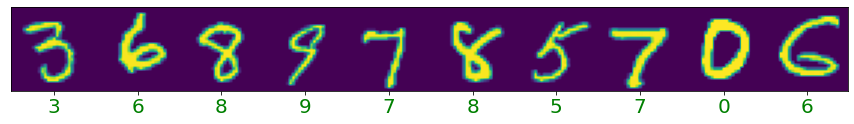

1/1 [==============================] - 0s 18ms/step


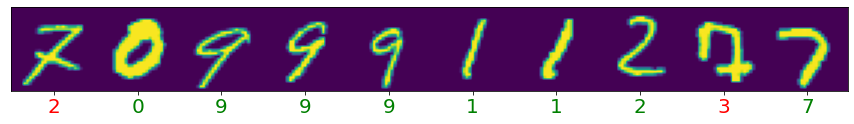

1/1 [==============================] - 0s 381ms/step


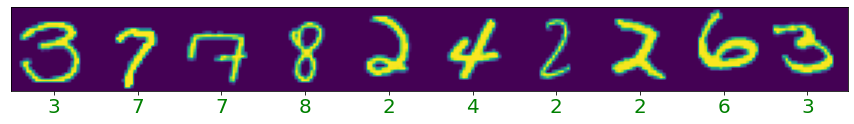

In [ ]:
model = get_model()
model.fit(x_train, y_train,
          batch_size=64,
          epochs=20,
          verbose=0,
          callbacks=[VisCallback(x_test, y_test)])

A correctly classified example is marked with a green label below the prediction where there's a red label below the predicted output when the prediction is incorrect.

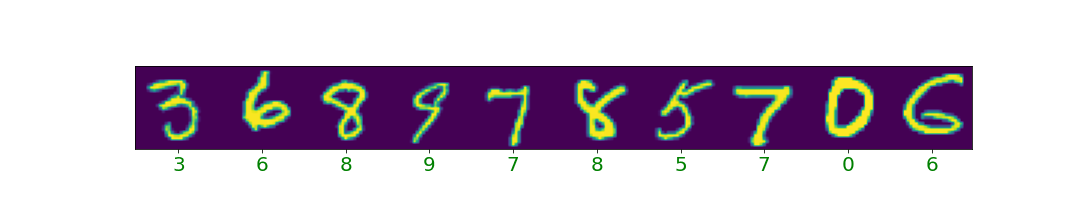

In [ ]:
# display GIF
SCALE = 60

# FYI, the format is set to PNG here to bypass checks for acceptable embeddings
IPyImage(GIF_PATH, format='png', width=15 * SCALE, height=3 * SCALE) 